<p style="font-family: times, serif; font-size:25pt; font-style:bold; color:black;">
   wrapSWASH-1D
</p>

<p style="font-family: times, Times New Roman; font-size:14pt; font-style:italic; color:black;">
    An easy-to-use Jupyter Notebook to model wave transformation over a shallow cross-shore profile with SWASH 
    <br>
</p>
<div style="font-family: times, Times New Roman; font-size:12pt; color:black; text-align: right"> Alba Ricondo, ricondoa@unican.es <br>GeoOcean Engineering Group, Universidad de Cantabria <br><br></div>

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
SWASH (Simulating WAves till SHore) is intented to be a free-surface, terrain-following, multi-dimensional hydrodynamic simulation model used to predict transformation of surface waves and rapidly varied shallow water flows in coastal waters. It solves the continuity and momentum equations, and optionally the equations for conservative transport of salinity, temperature and suspended load for both noncohesive sediment (e.g. sand) and cohesive sediment (mud, clay, etc.) (Zilema et al. 2008).
</span><br><br>

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
The purpose of this notebook is to provide the user a tool to run the open-source numerical model 1D SWASH giving some relevant advice in choosing the basic input. The simplicity of the commands inputs make the notebook suitable for performing different sensitivity analysis. For more information consult the implementation manual that can be found at <a href="http://swash.sourceforge.net/" target="_blank">SWASH home page.</a><br>
<br>
        
<hr size="5"/>

<span style="font-family: times, arial; font-size:14pt; font-weight:bold; color:dark;"> Table of Contents</span>

* [1. Data preprocessing](#1.-Data-preprocessing)
	* [1.1 Cross-shore profile](#1.1-Cross-shore-profile)
		* [From file](#From-file)
		* [From Pearson et al. 2017](#From-Pearson-et-al.-2017)
		* [Linear profile](#Linear-profile)
		* [Parabolic profile](#Parabolic-profile)
		* [Biparabolic profile (Bernabeu et al. 2003)](#Biparabolic-profile-(Bernabeu-et-al.-2003))
		* [Hand-made profile](#Hand-made-profile)
	* [1.2 Friction](#1.2-Friction)     
	* [1.3 Vegetation](#1.3-Vegetation) 
        
        
* [2. Boundary conditions](#2.-Boundary-conditions)
	* [2.1 Sea state](#2.1-Sea-state)
	* [2.2 Wind](#2.2-Wind)


* [3. Run](#2.-Run)
* [4. Data Postprocessing](#4.-Data-Postprocessing)
	* [4.1 Summary output video](#4.1-Summary-output-video)
	* [4.2 Wave propagation video](#4.2-Wave-propagation-video)
<br><br>

<div class="alert alert-block alert-info">
<b>Important:</b> At the beginning of each cell a note will indicate whether if the code must be runned optionally or necessarily 
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import python libraries
# basic
import sys
import os
import os.path as op
import glob

# common
import numpy as np
import pandas as pd

# interactive widgets
from ipywidgets import interact, interact_manual, interactive, HBox, Layout, VBox
from ipywidgets import widgets
from natsort import natsorted, ns
from moviepy.editor import *
from IPython.display import display, Image, Video

sys.path.insert(0, op.join(os.getcwd(),'..','..'))

# bluemath swash module (bluemath.DD.swash
from swash.wrap import SwashProject, SwashWrap
from swash.plots import SwashPlot
from swash.io import SwashIO

<br><br>

### **1. Data preprocessing**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    In this section, the computational grid is defined from the bathymetric data and, optionally, wave dissipation characteristics due to the bottom friction or vegetation. The input grids will be considered uniform and rectangular, with the computational grid covering the whole bathymetric region. <br>
    
User commands:

* `tendc`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> : duration of the simulation. The simulation will be long enough to get a steady-state solution. For a suitable simulation time at least 500 to 1000 waves are needed to reach stationary conditions. This time window does not include the spin-up time. It is assumed that the warm up takes at most 15% of the total time of the simulation ($ 0.15 · sp.tendc $). 


In [3]:
# Create the project directory and set the simulation period and grid resolution

p_data = op.abspath(op.join(os.getcwd(), '..', '..', 'data'))
p_proj = op.join(p_data, 'projects')  # swash projects main directory
n_proj = 'test'                                  # project name

sp = SwashProject(p_proj, n_proj)
sw = SwashWrap(sp)
si = SwashIO(sp)
sm = SwashPlot(sp)

sp.tendc = 1000                               # simulation period (SEC)
warmup = 0.15 * sp.tendc              # spin-up time (s) (default 15%)

#### **1.1 Cross-shore profile**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    Model boundaries should be far enough from the area of interest and away from steep topography to avoid unrealistic frictional or numerical dispersion effects but close enough to remain computationally feasible </span> <span style="font-family: times, Times New Roman; font-size:11pt; color:black; background:whitesmoke"> kh < 5. </span> </span> <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> As a recommendation, the area of interest should be kept at least two wave lengths away from the boundary. In the following cells, different input choices for defining the cross-shore profile will be given. </span>
 
* `dxL`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> : number of nodes per wavelength. This command sets the grid resolution from the number of nodes desired per wavelength in 1m depth (assuming that in the beach due to the infragravigity waves the water colum can reach 1m heigh). </span><br><br>

* `dxinp`: <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> The resolution of the bathymetric grid is not the same as that of the computational grid. It is advised to avoid extremely steep bottom slopes or sharp obstacles as much as posible. </span>  

#### **From file**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    Land points are defined as negative while wet points are defined as positive.
    </span>

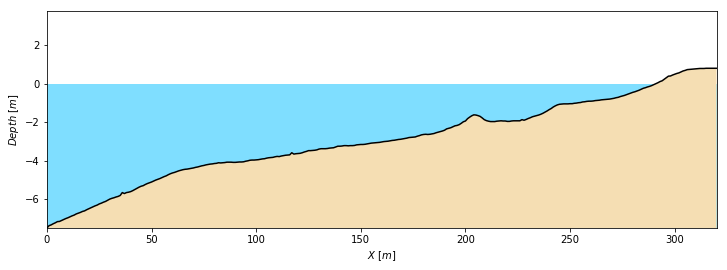

In [4]:
# Import depth FILE
sp.dxL = 30                                                                     # nº nodes per wavelength
sp.dxinp = 1                                                                    # bathymetry spacing resolution (m)
sp.depth = np.loadtxt(op.join(p_data, 'depth.bot'))        # depth file path

sm.plot_depthfile()  

<br>

#### **From Pearson et al. 2017**

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    Stuart et al. 2017 proposes an idealized reef profile morphology which could be used to predict wave transformation on reefs and subsequent flooding based on previous reef hydrodynamuc studies and sensitivity analysis. To better fit our approach, the hydrodynamic inputs have been separated from the reef morphology. The figure bellow illustrates the idealized reef profile modelled from the following representative parameters: the offshore water level (η0), fore reef slope (βf), reef flat width (Wreef), beach slope (βb), coefficient of friction (cf) and beach crest elevation (zbeach). 
</p>

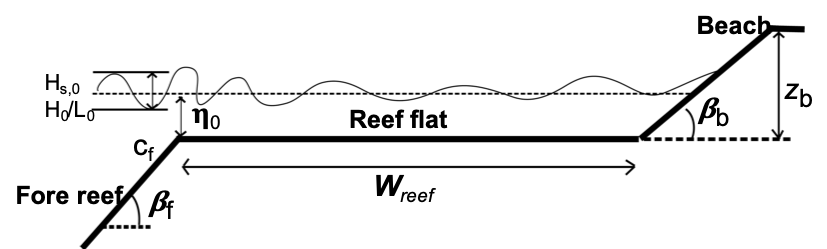

In [4]:
display(Image('HyCreWW_profile.png', width=700, height=400, embed=True))

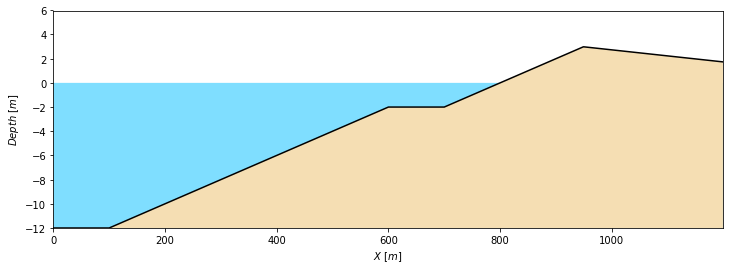

In [4]:
# Generate a reef morphologic configuration as described in Pearson et al. 2017
h0 = 10                    # offshore water level (m)
Slope1 =0.02           # fore reef slope
Slope2 = 0.02          # beach slope
Wreef = 100            # reef  flat width 
Wfore = 100            # length fore flume (advised 3 · L0)
bCrest = 5               # beach heigh (Zb)
emsl = 2                  # vertical displacement from reef to msl

sp.dxL = 30             # nº nodes per wavelength
sp.dxinp = 1            # bathymetry spacing resolution (m)
sp.depth = si.reef_profile(h0, Slope1, Slope2, Wreef, Wfore, bCrest, emsl) 
sm.plot_depthfile()   

<br>

#### **Linear profile**

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    
</p>

$y = mx + n$

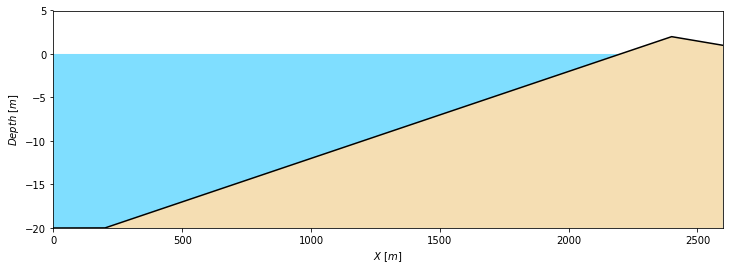

In [4]:
# Define a linear shape profile
h0 = 20                                # offshore water level (m)
bCrest = 2                           # beach heigh (m)
m =  0.01                             # beach profile slope
Wfore = 200 

sp.dxL = 30                         # nº nodes per wavelength
sp.dxinp = 1                        # bathymetry spacing resolution (m)
sp.depth = si.linear_profile(h0, bCrest, m ,Wfore)
sm.plot_depthfile()   

<br>

#### **Parabolic profile**

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    
</p>
$y = A x^{2/3}$

In [20]:
# Define a parabolic profile
%matplotlib inline
style = {'description_width': 'initial'}
interactive_plot = interact(si.parabolic_profile, 
                            h0 = widgets.IntText(value=10, description='Offshore water level (m)', style=style),
                            A = widgets.IntText(value=1, description='Parabola coefficient', style=style), 
                            xBeach = widgets.IntSlider(description='Beach length (m)', min=0, max=30, step=1, value=10, style=style), 
                            bCrest = widgets.IntSlider(description='Beach heigh (m)', min=0, max=30, step=1, value=10, style=style))

interactive(children=(IntText(value=10, description='Offshore water level (m)', style=DescriptionStyle(descrip…

<br>

#### **Biparabolic profile (Bernabeu et al. 2003)**

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    Bernabeu et al. 2003 presents a morphological model based on the equilibrium beach profile that relates the beach profile morphology with hydrodynamic and sedimentological parameters. The model assumes that the main wave energy dissipation process changes along the profile, from bottom friction to turbulence dissipation. This approach integrates a formulation for two separate sections, the surf and shoaling profiles that join at the breaker point (discontinuity point).<br>
Surf profile:<br>
</p>

\begin{equation*}
x_{r} = \Bigl(\frac{h}{A}\Bigr)^{3/2}+\frac{B}{A^{3/2}} (h)^{3}
\quad\quad \text{for $0≤x≤x_{r}$}
\end{equation*}


<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    Shoaling profile:
    </p>
   
\begin{equation*}
X = x - x_{0} = \Bigl(\frac{h}{C}\Bigr)^{3/2}+\frac{D}{C^{3/2}} (h)^{3}
\quad\quad \text{for $0≤x≤x_{r}$}
\end{equation*}


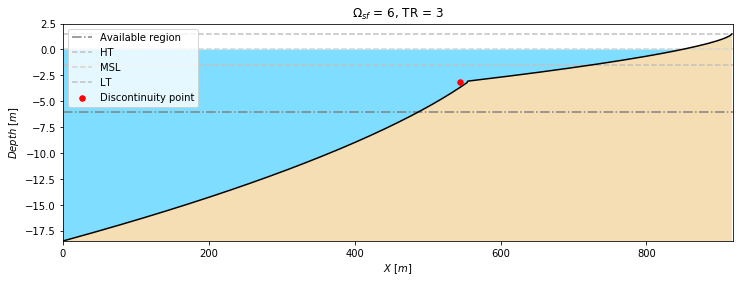

In [6]:
# Define a biparabolic profile as Berbeau et al. 2003 describes
h0 = 20                   # offshore water level  (m)
hs = 1.5                  # significant wave heigh (m)
omega_surf = 6      # intertidal dimensionless fall velocity (1 ≤ omega_surf ≤ 5)
TR = 3                    # tidal range (m)

sp.dxL = 30            # nº nodes per wavelength
sp.dxinp = 1           # bathymetry spacing resolution (m)
sp.depth = si.biparabolic_profile(h0, hs, omega_surf, TR)

<br>

<br>

#### **1.2 Friction** 

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
With this option the user can activate the bottom friction controlled by the Manning formula. As the friction coefficient may vary over the computational region, the friction data can be read from file or defined by specifyng the start and end point along it is defined the frictional area (e.g. reef). 
    </p>

In [ ]:
# Import friction FILE
sp.friction_file = True
sp.friction = True
sp.friction = np.loadtxt(op.join(p_data, 'friction.txt'))

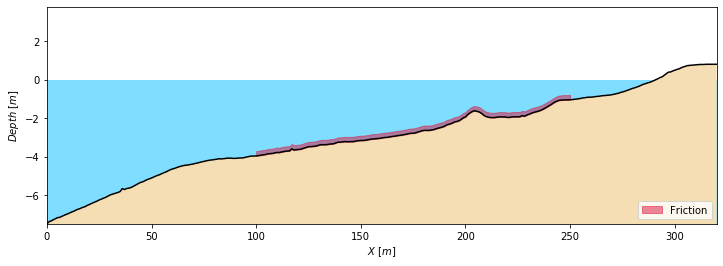

In [4]:
# Set a constant friction between two points of the profile 
sp.friction_file = False
sp.friction = True
sp.Cf = 0.01                       # manning frictional coefficient  (m^-1/3 s)
sp.cf_ini = 100                   # first point along the profile 
sp.cf_fin = 250                   # last point along the profile 
sm.plot_depthfile()

<br>

#### **1.3 Vegetation**

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
With this command the user can activate wave damping induced by aquatic vegetation. The vegetation is included in SWASH as a number of vertical cilinders (rigid plants) defined by the height, diameter and horizontally varying vegetation density.
    </p>

In [4]:
# Define plant shape characteristics and drag coefficient
sp.vegetation = True
sp.height =  0.5                       # plant height per vertical segment [m] 
sp.diamtr =  0.5                      # diameter of each plant stand per vertical segment [m]
sp.drag =  0.02                       # drag coefficient

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
  The horizontal vegetation density can be defined by means of a density varying file of setting a constant value:
    </p>

In [ ]:
# Horizontally varying vegetation density (m2) is to be read from FILE
sp.vegetation_file = True
sp.vegetation = np.loadtxt(op.join(p_data, 'plants.txt'))
sm.plot_depthfile()

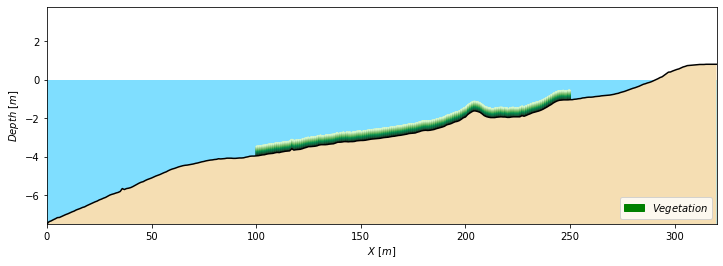

In [5]:
# Set a constant vegetation density along two points of the profile
sp.vegetation_file = False
sp.nstems =  100                    # nº plants stands per square meter
sp.np_ini = 100                      # first point along the profile 
sp.np_fin = 250                      # last point along the profile 
sm.plot_depthfile()

<br><br>

### **2. Boundary conditions**<br>
<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    The boundaries of the computational grid in SWASH are either land, beach or water. The wave condition is imposed on the west boundary of the computational domain, so that the wave propagation is pointing eastward. To simulate entering waves without some reflections at the wavemaker boundary, a weakly-reflective boundary condition allowing outgoing waves is adopted. For this test case, a time series synthesized from parametric information (wave height, period, etc.) will be given as wavemaker. This may either be defined as regular waves or irregular unidirectional waves by means of 1D spectrum. Both the initial water level and velocity components are set to zero.
</p>

#### **2.1 Sea state**<br>

<p style="font-family: times, Times New Roman; font-size:12pt; font-style:italic;  font-weight:bold; color:green;">
    Monochromatic waves
</p>

<p style="font-family: times, Times New Roman; font-size:11pt; color:black;">
   
</p>

In [5]:
# Define monochromatic, long-crested waves
h = 2                             # wave height (m)
t = 20                            # wave period (s)
WL = 1                          # water level (m)

waves = pd.DataFrame({"forcing":['Monochromatic'], "WL": [WL], "H":[h], "T":[t], "warmup":[warmup]})

<p style="font-family: times, Times New Roman; font-size:12pt; font-style:italic; font-weight:bold;  color:green;">
Bichromatic waves
</p>    
<p style="font-family: times, Times New Roman; font-size:11pt; color:black;">
   
</p>

In [5]:
# Define bichromatic waves
h = 2                     # wave height (m)    
t = 4                      # wave period of  frequency component 1
t2 = 4.5                 # wave period of frequency component 2
WL = 1                  # water level (m)

waves = pd.DataFrame({"forcing":['Bichromatic'], "WL": [WL], "H":[h], "T":[t], "T2":[t2], "warmup":[warmup]})

<p style="font-family: times, Times New Roman; font-size:12pt; font-style:italic; font-weight:bold; color:green;">
Jonswap spectrum
</p>   

In [5]:
# Define JONSWAP spectrum by means of the following spectral parameters
hs = 1                        # significant wave height (m)
tp = 12                           # peak period (s)
gamma = 3.3                # peak enhancement parameter of the JONSWAP spectrum
WL = 0                         # water level (m)

waves = pd.DataFrame({"forcing":['Jonswap'],"WL": [WL], "Hs":[hs], "Tp":[tp], "gamma":[gamma], "warmup":[warmup]})

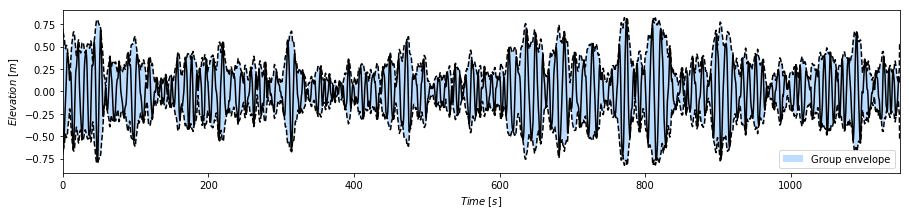

In [6]:
# Create wave series and save 'waves.bnd' file
sp.deltat = 0.5            # delta time over which the wave series is defined
series = sw.make_waves_series(waves) 
sm.plot_waves(waves, series)                      

<br>

#### **2.2 Wind**

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
The user can optionally specify wind speed, direction and wind drag assuming constant values in the domain. As the test case is using cartesian coordinates, please set the direction where the wind cames from.
</p>

In [7]:
# Define wind parameters
sp.wind = True
sp.Vel = 20            # wind speed  at 10 m height (m/s)
sp.Wdir = 0           # wind direction at 10 m height (º)
sp.Ca = 0.0026     # dimensionless coefficient (default 0.002)

<br><br>

### **3. Run**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
In the following, a series of predefined options have been choosen: <br></span>

* <span style="font-family: times, Times New Roman; font-size:12pt; color:black;font-weight:bold; background:ivory;">Grid resolution</span> <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> is determined through a number of points per wavelength criteria: Courant number for numerical stability, number of points per wavelength, and manual upper and lower limits for grid cell sizes.<br></span>

* <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">The default value for the maximun </span><span style="font-family: times, Times New Roman; font-size:12pt; color:black; background:ivory; font-style:italic; font-weight:bold;">wave breaking steepness</span> <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">parameter is $ \alpha = 0.6$<br></span>

* <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> For high, nonlinear waves, or wave interaction with structures with steep slopes (e.g. jetties, quays), a Courant number of 0.5 is advised. Here, a dynamically adjusted </span><span style="font-family: times, Times New Roman;  color:black; font-size:12pt; background:ivory; font-weight:bold;">time step</span> <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> controlled by a Courant number range of (0.1 - 0.5) is implemented<br></span>


<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
User parametes:<br></span>

* `Nonhydrostatic`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">to include the non-hydrostatic pressure in the shallow water equations. Hydrostatic pressure assumption can be made in case of propagation of long waves, such as large-scale ocean circulations, tides and storm surges. This assumption does not hold in case of propagation of short waves, flows over a steep bottom, unstable stratified flows, and other small-scale applications where vertical acceleration is dominant </span>
* `vert`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">this command set the number of vertical layers in case that the run will be in multi-layered mode </span><br><br>


In [7]:
# Create swash wrap 
sp.Nonhydrostatic = True               # True or False
sp.vert = 1                                       # vertical layers
sp.delttbl = 1           # time between output fields (s)

sw = SwashWrap(sp)
waves = sw.build_cases(waves)

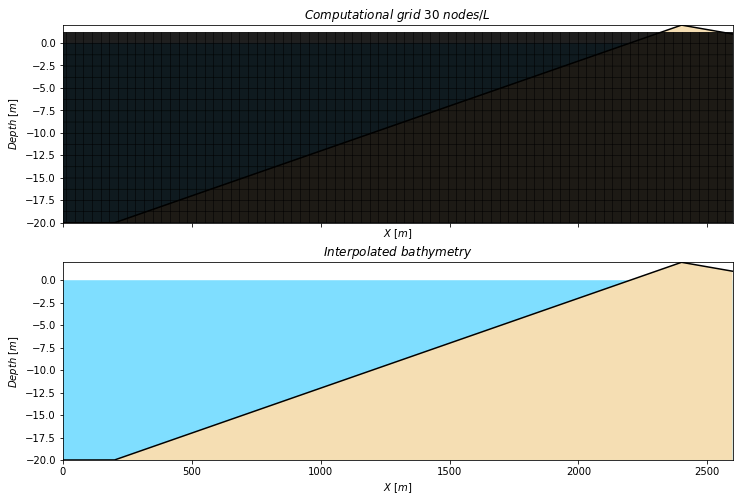

In [8]:
# Run to see the computational grid and bathymetry interpolated
sw.plot_grid(waves)

In [9]:
# Show the 'input.sws' file to check input grids, numerics, physis and output quantities
sws_file = sw.print_wraps(waves)

$Project name
PROJECT 'test' '0000'
$
$Set water level
SET LEVEL=0
$
$(1D-mode, flume) or (2D-mode, basin)
MODE DYNanic ONED
COORD CARTesian
$Computational grid: geographic location, size, resolution and orientation
CGRID 0 0 0 2599 0 2086 0
$
$Multi-layered mode
VERT 1
$
$Reading bathymetry values from file
INPGRID BOTTOM 0 0 0 2599 0 1.00 1
READINP BOTTOM 1 'depth.bot' 1 0 FREE
$
$Initial values for flow variables
INIT ZERO
$
$Hydraulic boundary conditions
BOU SIDE W CCW BTYPE WEAK CON SERIES 'waves.bnd'
BOU SIDE E CCW BTYPE RADIATION 
$
$Physics
BREAK
$Numerics
NONHYDrostatic
$
$Output quantities
DISCRET UPW MOM
DISCRET UPW UMOM H NONE
DISCRET UPW WMOM H NONE
$
$Time integration
TIMEI 0.1 0.5
$
QUANTITY XP hexp=10
QUANT RUNUP delrp 0.01
$
CURVE 'line' 0 0 2599 2599 0
TABLE 'line' HEAD 'output.tab' TSEC XP YP BOTL WATL QMAG OUTPUT 0 1 SEC
$
TABLE 'NOGRID' HEAD 'run.tab' TSEC RUNUP OUTPUT 0 1 SEC
$
$Starts computation
TEST  1,0
COMPUTE 000000.000 0.02 SEC 001910.000
STOP
$


In [8]:
# Run cases
sw.run_cases()

SWASH CASE: 0000 SOLVED


<br><br>

### **4. Data Postprocessing**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
    Different output quantities will be given here to go over the different wave transformation processes including wave propagation, dispersion, flooding and drying, moving shoreline, surf-beat, infragravity waves, set-up induced by wave breaking, run-up and overtopping discharge. <br><br>

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
    To this end, the time-dependent <span style="font-family: times, Times New Roman; font-weight:bold; font-size:12pt; color:black; background:ivory"> surface elevation </span> is stored at every grid point for every time step. After removing the warmup time from the sea surface series, a FFt is applied to obtain its representation in the frequency domain. A further classification is given by spliting the wave frequency into incident waves IC (0.04 - 1), infragravity waves IG (0.004 - 0.04) and very low frequency VLF (0.001 - 0.004). </span><br><br>

    
<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
    The <span style="font-family: times, Times New Roman; font-size:12pt; color:black;font-weight:bold; background:ivory">run-up heigh </span> is computed by the intersection between free surface and bottom level considering a minimun  depth of 1cm after each time step. </span><br><br>

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
    The <span style="font-family: times, Times New Roman; font-size:12pt; color:black;font-weight:bold; background:ivory"> mean wave overtopping discharge </span> q (ms/l) is outputted at the highest elevation point.
</span> <br><br>

In [8]:
# Extract output from files
t_video = 50    # Video duration (s)
QR = sw.postprocessing(waves, t_video)


Output table

<xarray.Dataset>
Dimensions:  (Tsec: 1150, Xp: 321, Yp: 1)
Coordinates:
  * Xp       (Xp) float64 0.0 1.0 2.0 3.0 4.0 ... 316.0 317.0 318.0 319.0 320.0
  * Yp       (Yp) float64 0.0
  * Tsec     (Tsec) float64 0.0 1.02 2.01 3.0 ... 1.147e+03 1.148e+03 1.149e+03
Data variables:
    Botlev   (Xp, Yp, Tsec) float64 8.5 8.5 8.5 8.5 8.5 ... 0.2 0.2 0.2 0.2 0.2
    Watlev   (Xp, Yp, Tsec) float64 0.0 -0.204 -0.0374 ... 0.065 0.0638 0.0627
    Qmag     (Xp, Yp, Tsec) float64 2.011 1.185 0.3875 ... 0.357 0.3574 0.3576
    Runlev   (Tsec) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

Processed data: Fft transformation

        Xi    Hmax      Hrms        Hs       HIC       HIG      HVLF   E_max  \
0      0.0  0.7865  0.366258  0.564493  0.563668  0.030051  0.011112  0.4292   
1      1.0  0.7887  0.364448  0.560221  0.559398  0.029921  0.011072  0.4352   
2      2.0  0.7789  0.364127  0.557215  0.556397  0.029743  0.011100  0.4440   
3      3.0  0.7608  0.365017  0.

<br><br>

#### **4.1 Summary output video**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
    Under the idealised shallow-water conditions considered here, the wave spectrum evolves essentially as in deep water: from the high frequencies to lower frequencies while the area under the spectrum increases (and therefore also the significant wave height). In order to analyze the wave transformation processes along the cross-shore profile, a number of wave gates have been choseen to record the numerical results. Here bellow, the figures created in the previous step tend to synthesize the different output quantities. </span><br>

In [8]:
# Concatenate figures into video
path = op.join(sp.p_main, "0000","X")
file_list = os.listdir(path)
files = natsorted(file_list)

clips = []
for filename in files:
    clips.append(ImageClip(op.join(path, filename)).set_duration(1))

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("stats.mp4", fps=40)

t:   0%|          | 4/2520 [00:00<01:12, 34.57it/s, now=None]

Moviepy - Building video stats.mp4.
Moviepy - Writing video stats.mp4



Moviepy - Done !
Moviepy - video ready stats.mp4


In [9]:
# Show sumarize statististics video
Video('stats.mp4', embed=True)

<br><br>

#### **4.2 Wave propagation video**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
    Finally, another video shows the waves propagating and reaching the coastline. Visualizing the wave breaking line and wave steepness may be useful to evaluate the quality of the previously selected inputs.
</span><br>

In [10]:
# Concatenate figures into video
path = op.join(sp.p_main, "0000","Time")
file_list = os.listdir(path)
files = natsorted(file_list)

clips = []
for filename in files:
    clips.append(ImageClip(op.join(path, filename)).set_duration(1))

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("propagation.mp4", fps=40)

t:   0%|          | 6/8000 [00:00<02:40, 49.88it/s, now=None]

Moviepy - Building video propagation.mp4.
Moviepy - Writing video propagation.mp4



Moviepy - Done !
Moviepy - video ready propagation.mp4


In [11]:
# Show propagation waves video
Video('propagation.mp4', embed=True)